In this notebook, the autoencoder model is trained with the same convolutional layer specifications as used in the predictive model. After training, the MSOA street graphs are passed through and embeddings retrieved. Embeddings are clustered, their traits analysed, and then clusters projected across maps.

### Import libraries

In [26]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
import os.path as osp

2.1.2


In [27]:
import torch_geometric.transforms as T
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GINConv, InnerProductDecoder, GAE, global_mean_pool, MLP
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling

In [28]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
import matplotlib.cm as cm
import contextily as cx
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import networkx as nx
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score

In [30]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

### Define dataset, load from processed files

In [6]:
class EW_msoa_graphs(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        
    @property
    # make list of cities in the processed .pt file
    def processed_file_names(self):
        return [f'{msoa}' for msoa in os.listdir(self.root) if msoa.endswith('.pt')]

    # find the number of files in the dataset
    def len(self):
        return len(self.processed_file_names)

    # fetch the files by finding name from index number
    def get(self, idx):
        file_name = self.processed_file_names[idx]  # raise IndexError if idx is out of range
        return self.load_graph(os.path.join(self.root, file_name))

    def load_graph(self, file_path):
        try:
            return torch.load(file_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"File {file_path} not found.")

    def get_by_filename(self, filename):
        # method to load a specific graph directly by filename
        if filename in self.processed_file_names:
            return self.load_graph(os.path.join(self.root, filename))
        else:
            raise FileNotFoundError(f"File {filename} not found in dataset directory.")

In [7]:
dataset = EW_msoa_graphs(root='graphs/graphs_n_amenities_15min')

#### Split train, test

In [10]:
dataset_size = dataset.len()  # get the total number of graphs in the dataset
train_size = int(0.8 * dataset_size)  # calculate 80% of the dataset size

# set seeds for random operations so that results are reproducible
np.random.seed(42)
torch.manual_seed(42)

# shuffle the dataset using a consistent random seed
shuffled_dataset = dataset.shuffle()

train_dataset = shuffled_dataset[:train_size]
test_dataset = shuffled_dataset[train_size:]
    
# dataLoader with specific seed for reproducibility in the sampling process
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Train autoencoder

In [16]:
class GINEncoder(torch.nn.Module):
    def __init__(self, num_features, num_layers, hidden_channels):
        super().__init__()

        # Initial linear transformation layer
        self.initial_layer = torch.nn.Linear(num_features, hidden_channels)

        # build convolutional layer sandwich with MLP
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            mlp = MLP([hidden_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            in_channels = hidden_channels
            out_channels = hidden_channels

        self.return_embeddings = False  # Initialize flag

    def forward(self, x, edge_index, batch):
        # pass through initial layer
        x = self.initial_layer(x)
        # pass through convolutional layers
        for conv in self.convs:
            x = conv(x, edge_index)
        # retrieve pooled embeddings for further analysis if requested
        embeddings = global_mean_pool(x, batch)
        
        if self.return_embeddings:
            return embeddings
        
        # otherise get unpooled embeddings for passing to the decoder
        return x

    def enable_embedding_output(self):
        self.return_embeddings = True

    def disable_embedding_output(self):
        self.return_embeddings = False

In [43]:
# Model and optimizer
num_features = 1
num_layers = 3
hidden_channels = 64
encoder = GINEncoder(num_features, num_layers, hidden_channels)
decoder = InnerProductDecoder()
model = GAE(encoder=encoder, decoder=decoder)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 30
train_loss_avg = []

In [44]:
def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        # encode data as embedding
        encoded_data = model.encode(data.x, data.edge_index, data.batch)

        # create positive, negative edge indexes for loss 
        pos_edge_index = data.edge_index
        neg_edge_index = negative_sampling(edge_index=data.edge_index, num_nodes=data.num_nodes,
                                           num_neg_samples=data.edge_index.size(1))
        # calculate loss / reconstruction error
        loss = model.recon_loss(encoded_data, pos_edge_index, neg_edge_index)

        # backpropagation
        loss.backward()

        #step optimizer
        optimizer.step()
        train_loss_avg[-1] += loss.item()

    if (epoch + 1) % 1 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, train_loss_avg[-1]))

In [45]:
for epoch in range(epochs):
    loss = train()
    train_loss_avg.append(loss)

Epoch [1 / 30] average reconstruction error: 33.279526
Epoch [2 / 30] average reconstruction error: 27.857764
Epoch [3 / 30] average reconstruction error: 27.255065
Epoch [4 / 30] average reconstruction error: 26.619139
Epoch [5 / 30] average reconstruction error: 26.806104
Epoch [6 / 30] average reconstruction error: 26.264611
Epoch [7 / 30] average reconstruction error: 26.183983
Epoch [8 / 30] average reconstruction error: 26.240587
Epoch [9 / 30] average reconstruction error: 25.789230
Epoch [10 / 30] average reconstruction error: 25.916285
Epoch [11 / 30] average reconstruction error: 25.695243
Epoch [12 / 30] average reconstruction error: 25.610343
Epoch [13 / 30] average reconstruction error: 25.597255
Epoch [14 / 30] average reconstruction error: 25.513784
Epoch [15 / 30] average reconstruction error: 25.403375
Epoch [16 / 30] average reconstruction error: 25.556565
Epoch [17 / 30] average reconstruction error: 25.521557
Epoch [18 / 30] average reconstruction error: 25.368873
E

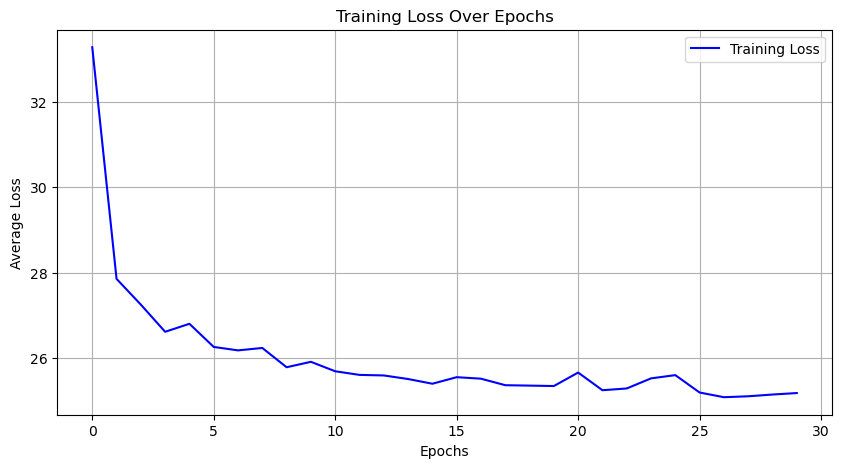

In [47]:
# plot training loss
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(train_loss_avg, label='Training Loss', color='blue')#, marker='o')  # Plot the training loss
plt.title('Training Loss Over Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Average Loss')  # Label for the y-axis
plt.grid(True)  # Enable grid
plt.legend()  # Add a legend
plt.show()  # Display the plot

In [48]:
# evaluate ability of encoder to encode on unseen data
def testevaluate():
    model.eval()
    auc, ap = [], []
    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            z = model.encode(data.x, data.edge_index, data.batch)
            pos_edge_index = data.edge_index
            neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=data.num_nodes,
                                               num_neg_samples=pos_edge_index.size(1))
            auc_score, ap_score = model.test(z, pos_edge_index, neg_edge_index)
            auc.append(auc_score)
            ap.append(ap_score)
    return sum(auc) / len(auc), sum(ap) / len(ap)

In [49]:
auc, ap = testevaluate()
print(f'Test AUC: {auc}, Test AP: {ap}')

Test AUC: 0.9199068980883569, Test AP: 0.8856335074199876


In [50]:
# compare with ability to code on seen data - testing for overfitting
def trainevaluate():
    model.eval()
    auc, ap = [], []
    for data in train_loader:
        data = data.to(device)
        with torch.no_grad():
            z = model.encode(data.x, data.edge_index, data.batch)
            pos_edge_index = data.edge_index
            neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=data.num_nodes,
                                               num_neg_samples=pos_edge_index.size(1))
            auc_score, ap_score = model.test(z, pos_edge_index, neg_edge_index)
            auc.append(auc_score)
            ap.append(ap_score)
    return sum(auc) / len(auc), sum(ap) / len(ap)

In [51]:
auc, ap = trainevaluate()
print(f'Train AUC: {auc}, Train AP: {ap}')

Train AUC: 0.9193736240853073, Train AP: 0.8844273073743432


# Get embeddings

In [38]:
# Import geography file, clean
msoa = gpd.read_file("geographies/MSOA_2011_EW_BFC_shp/MSOA_2011_EW_BFC.shp")
nonrural_MSOAs = pd.read_csv('geographies/nonrural_MSOAs.csv')
# Drop rural MSOAs
msoa = msoa.merge(nonrural_MSOAs, on='MSOA11CD', how='inner')
# Drop Welsh MSOAs
msoa = msoa[~msoa['MSOA11CD'].str.startswith('W02')]

In [52]:
model = model
model.encoder.enable_embedding_output()
model.eval()

# Initialize empty list to store data
data_list = []

def load_graph(filename):
    return torch.load(filename)
    
# Loop through each MSOA and get embeddings
with torch.no_grad():
    for index, row in msoa.iterrows():
        file_path = os.path.join('graphs/graphs_n_amenities_15min', row['MSOA11CD'] + '.pt')
        if os.path.exists(file_path):  # Check if the graph file exists
            graph = load_graph(file_path)
            # Get single graph per batch, no batch dimension needed
            batch = torch.zeros(graph.num_nodes, dtype=torch.long)
            # Get embedding
            embeddings = model(graph.x, graph.edge_index, batch)
            # Ensure embeddings are detached and moved to CPU for DataFrame usage
            embeddings = embeddings.squeeze().detach().cpu().numpy()
            # Append MSOA code and embeddings to data list
            data_list.append([row['MSOA11CD']] + embeddings.tolist())

# Create column names
column_names = ['MSOA11CD'] + [f'embedding_{i}' for i in range(hidden_channels)]

# Create a DataFrame
embeddings_df = pd.DataFrame(data_list, columns=column_names)

In [54]:
embeddings_df.to_csv('autoencoder_embeddings.csv', index=False)

# Cluster embeddings
This was done on Google Colab due to kernel crashing

In [ ]:
embeddings = pd.read_csv('autoencoder_embeddings.csv')
embeddings.set_index('MSOA11CD', inplace=True)

In [ ]:
scaled_embeddings = StandardScaler().fit_transform(embeddings)

In [ ]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_embeddings)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_embeddings)

In [ ]:
embeddings['cluster'] = kmeans.labels_

In [ ]:
embeddings = embeddings.reset_index()

In [ ]:
embeddings.to_csv('clustered_autoencoder_embeddings.csv', index=False)

# Plot Cluster Attributes

In [31]:
# Import MSOA features and the clustered embeddings
aembeddings_raw = pd.read_csv('clustered_autoencoder_embeddings.csv')
accessibility = pd.read_csv('clean_y_values/y_n_amenities_15min.csv')
msoa_pop = pd.read_csv("geographies/msoa_pop.csv")
nodal_degrees = pd.read_csv('clean_y_values/graph_node_edge_data.csv')

In [32]:
# Fix MSOA population data
msoa_pop = msoa_pop.iloc[3:].reset_index(drop=True)
col_names = msoa_pop.iloc[0]  # Capture the 5th row which is now at index 0 after the drop
msoa_pop = msoa_pop[1:]  # Remove the first row
msoa_pop.columns = col_names
msoa_pop = msoa_pop[['MSOA Code', 'All Ages']]
msoa_pop.rename(columns={'MSOA Code': 'MSOA11CD', 'All Ages': 'USUALRES'}, inplace=True)
msoa_pop['USUALRES'] = msoa_pop['USUALRES'].str.replace(',', '', regex=True)
msoa_pop['USUALRES'] = pd.to_numeric(msoa_pop['USUALRES'], errors='coerce')
msoa_pop.dropna(subset=['USUALRES'], inplace=True)
msoa_pop['USUALRES'] = msoa_pop['USUALRES'].astype(int)

In [33]:
# Get population and road density
nodal_degrees = pd.merge(nodal_degrees, accessibility, on='MSOA11CD')
nodal_degrees = pd.merge(nodal_degrees, msoa_pop, on='MSOA11CD')
nodal_degrees['population_density'] = nodal_degrees['USUALRES'] / nodal_degrees['area']
nodal_degrees['road_density'] = nodal_degrees['edge_length'] / nodal_degrees['area']
density = nodal_degrees[['MSOA11CD', 'population_density', 'road_density']]

In [34]:
# merge embeddings with these details
aembeddings = pd.merge(aembeddings_raw, nodal_degrees, on='MSOA11CD')

In [35]:
# This cell and the next just changes cluster names so patterns are easier to recognize
aembeddings['cluster'] = aembeddings['cluster'].replace({2: 3, 3: 2})

In [36]:
aembeddings['cluster'] = aembeddings['cluster'].replace({0:1, 1:2, 2:3, 3:4})

In [19]:
# Define boxplot for cluster traits
def boxplot(column, column_title):
    # Set the style
    sns.set(style="whitegrid")

    # Colors for each boxplot
    colors = ['#F94144', '#F9C74F', '#43AA8B', '#277DA1']

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create the boxplot with seaborn
    box_plot = sns.boxplot(x='cluster', y=column, data=aembeddings, ax=ax,
                           palette=colors,  # Custom colors for each box
                           medianprops={'color': 'black', 'linewidth': 2},  # White median line
                           flierprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'none', 'markersize' : 2})  # Custom outlier symbols

    # Set titles and labels
    ax.set_title(f'{column_title} by Cluster')
    ax.set_xlabel('')  # This line removes the x-axis label
    ax.set_ylabel(f'{column_title}')

    # Set new x-axis labels
    new_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
    ax.set_xticklabels(new_labels)

    # Remove the grid, unnecessary title
    ax.grid(False)
    plt.suptitle('')

    # Show the plot
    plt.show()

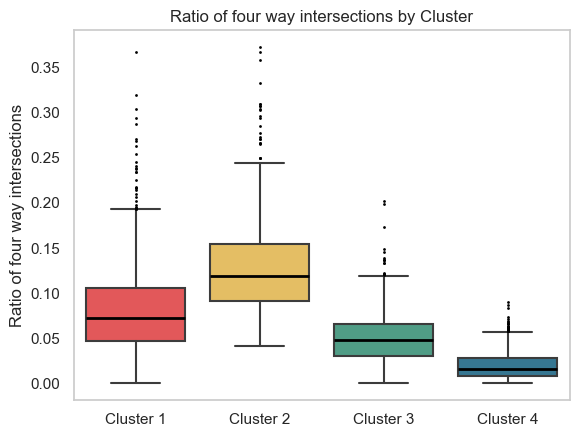

In [25]:
column = 'degree_4'
column_title = 'Ratio of four way intersections'
boxplot(column, column_title)

# Plot Cluster Spatial Distribution

In [127]:
# download fresh clustered embeddings, fix the names again
aembeddings = pd.read_csv('clustered_autoencoder_embeddings.csv')
aembeddings['cluster'] = aembeddings['cluster'].replace({2: 3, 3: 2})
aembeddings['cluster'] = aembeddings['cluster'].replace({0:1, 1:2, 2:3, 3:4})

In [79]:
# download MSOA geography
msoa = gpd.read_file('geographies/MSOA_2011_EW_BFC_shp/MSOA_2011_EW_BFC.shp')

In [131]:
# plot urban areas with topology clusters
def plot_zoomed_cities(df, column_name, legend_title, plot_title, cmap):    
    # Define layout with explicit placeholders for the axes
    layout = [
        ["A", "B"],
        ["C", "D"]
    ]
    # Define the figure and axes with adjusted width ratios to accommodate the legend
    fig, axs = plt.subplot_mosaic(layout, figsize=(11, 10), constrained_layout=True,
                                  gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})

    # Assume 'msoa' is a predefined GeoDataFrame that matches with 'df'
    gdf = msoa.merge(df, on='MSOA11CD', how='left')

    city_centers = [(53.491013, -2.314446), (54.983156, -1.608169), 
                    (52.497836, -1.965555), (51.506392, -0.112552)]
    city_names = ["Manchester", "Newcastle", "Birmingham", "London"]

    # Create a GeoDataFrame with city centers in EPSG:4326
    city_centers_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([lng for lat, lng in city_centers], 
                                                                    [lat for lat, lng in city_centers]), 
                                        crs="EPSG:4326")
    
    # Transform to OSGB36 / British National Grid
    city_centers_gdf = city_centers_gdf.to_crs(epsg=27700)

    buffer = 25000  # Buffer in meters (adjust if necessary)

    # Prepare legend patches
    categories = gdf[column_name].dropna().unique()
    categories.sort()
    legend_patches = [Patch(color=plt.get_cmap(cmap)(i / len(categories)), label=f'{int(cat)}') for i, cat in enumerate(categories)]

    for pos, (index, row) in zip(['A', 'B', 'C', 'D'], city_centers_gdf.iterrows()):
        ax = axs[pos]
        point = row.geometry
        minx, maxx = point.x - buffer, point.x + buffer
        miny, maxy = point.y - buffer, point.y + buffer

        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        
        plot = gdf.plot(column=column_name, ax=ax, alpha=0.8, categorical=True, legend=False, cmap=cmap, edgecolor='black', linewidth=0.1)

        # Add North Arrow
        ax.annotate('N', xy=(0.96, 0.15), xycoords='axes fraction', xytext=(0.96, 0.1), 
            textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle="->"), 
            ha='center')

        # Add Scale Bar
        scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower right', scale_loc='top')
        ax.add_artist(scalebar)

        try:
            cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom=10)
        except Exception as e:
            print(f"Failed to add basemap: {e}")

        ax.set_title(city_names[index], position=(0.5, -0.1))
        ax.set_xticks([])
        ax.set_yticks([])

        # Only for subplot B, add legend manually
        if pos == 'B':
            ax.legend(handles=legend_patches, title=legend_title)

    # Add an overall title
    fig.suptitle(plot_title, fontsize=16)
    
    plt.show()

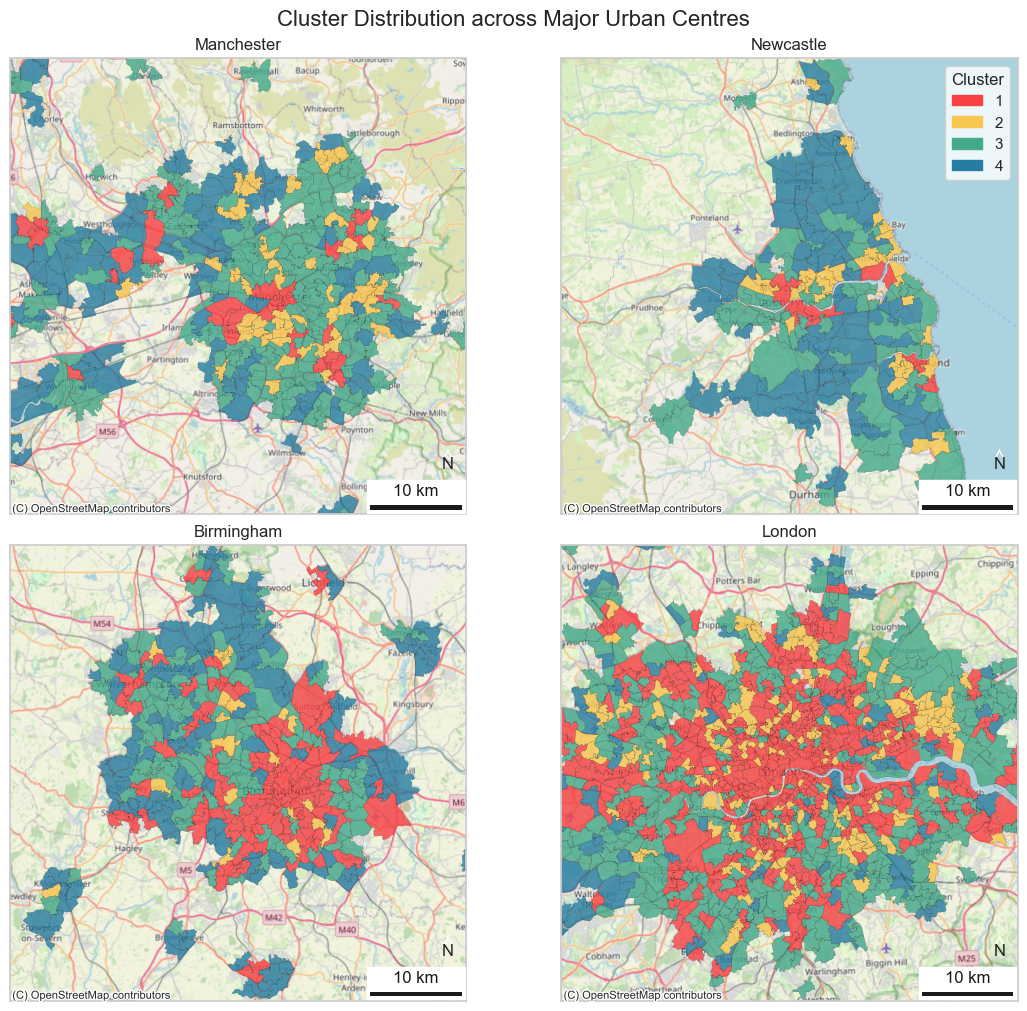

In [132]:
df = aembeddings
column_name='cluster'
legend_title='Cluster'
plot_title='Cluster Distribution across Major Urban Centres'
color_list=['#F94144', '#F9C74F', '#43AA8B', '#277DA1']
cmap = ListedColormap(color_list)

plot_zoomed_cities(df, column_name, legend_title, plot_title, cmap)